In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import sys
print(sys.getrecursionlimit())
from scipy.integrate import solve_ivp
sys.setrecursionlimit(5000)

3000


In [2]:
def ColMax(x,i):
    mx =0;
    for j in range (len(x)):
        mx = max(mx, x[j][i])
    return mx

def Beam(t,x,k0,k2,Cp,neta,Rl,w,A,m,c):
    dxdt=np.zeros(len(x))
    dxdt[0]=x[1];
    dxdt[1]=(1/m)*(-neta*A*math.sin(w*t) - c*x[1] -k2*x[0]- k0*x[2]);
    dxdt[2]=(1/(Cp))*(-(x[2]/Rl)+k0*x[1]);
    return dxdt

# Unoptimized Linear Beam

In [3]:
E=np.array([170e9,300e9]); # young's modulus
t1 = 55e-6; # thickness of beam
t2 = 1e-6; # thickness of piezo
T=np.array([t1,t2]);
length = 10e-3;
width = 1e-3;
lp = length/3;
density=np.array([2330,3320]);
n = 2;  #E.size();
Area=T*width;
volume=width*length*T;
mass=sum(volume*density);
m_added=1e-6; #%mass added to reduce the resonant frequency
meff=0.37*mass+m_added;
S=np.zeros(n);
for i in range(n):
    S[i]=sum(T[0:i+1])-T[i]/2;
N=np.array(E/E[0]);
Neu3=sum(Area*N*S)/sum(Area*N); #% neutral_axis_location from bottom
#%calculation of Hu,Hl
HL=np.zeros(n);
for i in range(n):
    HL[i]=(sum(T[0:i+1])-Neu3);
HU=np.array(HL-T);
KL=width*sum(E*abs(HU**3-HL**3))/(4*(length**3)); #%linear stifness
wn=(abs(KL)/meff)**0.5;
fn=wn/(2*3.14);
Q=20;
c=wn*meff/Q;  # damping coefficient
e0=8.85e-12;
er=8.8;
Cp=width*lp*e0*er/t2; # capacitance of piezo
em_couple=0.01; # K33_square 
k0=(em_couple*KL*Cp)**0.5; # em coupling coefficient
Rl=1/(2*3.14*Cp*fn); # load ressistance
print("Resonant frequency fn: ",fn);
tspan=np.linspace(0,2,2500); #%time span of simulation
x0=[0,0,0];
A=5;
solF=solve_ivp(lambda T,X: Beam(T,X,k0,KL,Cp,meff,Rl,wn,A,meff,c),[0,2],x0,rtol=1e-6,t_eval=tspan); # at resonant frequency
tF=np.array(solF.t);
xF=np.array(solF.y);
voltF = max(xF[2,int(0.7*len(xF[2])):len(xF[2])]); 
print("Maximum Voltage: ",voltF); 

Resonant frequency fn:  181.85224397030035
Maximum Voltage:  0.42415166415551353


In [4]:
f=np.linspace(50,250,201);
w1=2*3.14*f;

volt = np.zeros(len(w1));
disp = np.zeros(len(w1));

for i in range(len(w1)):
    sol=solve_ivp(lambda T,X: Beam(T,X,k0,KL,Cp,meff,Rl,w1[i],A,meff,c),[0,2],x0,rtol=1e-6,t_eval=tspan);
    t=np.array(sol.t);
    x=np.array(sol.y);
    volt[i] = max(x[2,int(0.7*len(x[2])):len(x[2])]);
    disp[i] = max(x[0,int(0.7*len(x[0])):len(x[0])]);
    n0 = len(x[0]); 
    x0 = x[:,n0-1];
    print("iteration",i,"completed");

iteration 0 completed
iteration 1 completed
iteration 2 completed
iteration 3 completed
iteration 4 completed
iteration 5 completed
iteration 6 completed
iteration 7 completed
iteration 8 completed
iteration 9 completed
iteration 10 completed
iteration 11 completed
iteration 12 completed
iteration 13 completed
iteration 14 completed
iteration 15 completed
iteration 16 completed
iteration 17 completed
iteration 18 completed
iteration 19 completed
iteration 20 completed
iteration 21 completed
iteration 22 completed
iteration 23 completed
iteration 24 completed
iteration 25 completed
iteration 26 completed
iteration 27 completed
iteration 28 completed
iteration 29 completed
iteration 30 completed
iteration 31 completed
iteration 32 completed
iteration 33 completed
iteration 34 completed
iteration 35 completed
iteration 36 completed
iteration 37 completed
iteration 38 completed
iteration 39 completed
iteration 40 completed
iteration 41 completed
iteration 42 completed
iteration 43 complete

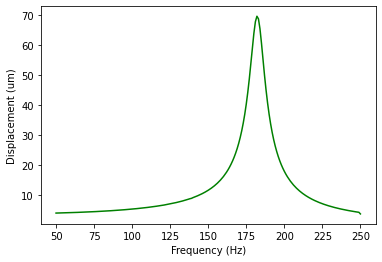

In [5]:
plt.plot(f,disp/1e-6, color='g');
plt.xlabel('Frequency (Hz)');
plt.ylabel('Displacement (um)');
plt.show();

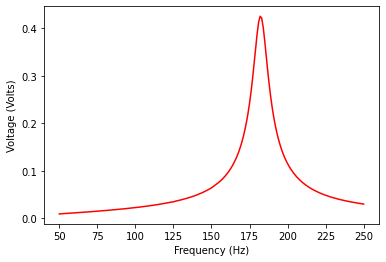

In [6]:
plt.plot(f,volt, color='r');
plt.xlabel('Frequency (Hz)');
plt.ylabel('Voltage (Volts)');
plt.show();

# Optimized Linear Beam (Genetic Algorithm)

In [7]:
def cantilever_opt(t1,t2,width,length,lp,k0):
    E=np.array([170e9,300e9]); # young's modulus
    T=np.array([t1,t2]); # thickness
    density=np.array([2330,3320]);
    n = 2; #E.size();
    Area=T*width;
    volume=width*length*T;
    mass=sum(volume*density);
    m_added=1e-6; #%mass added to reduce the resonant frequency
    meff=0.37*mass+m_added;

    e0=8.85e-12;
    er=8.8;
    Cp=width*lp*e0*er/t2; # capacitance of piezo

    S=np.zeros(n);
    for i in range(n):
        S[i]=sum(T[0:i+1])-T[i]/2;
    N=np.array(E/E[0]);

    Neu3=sum(Area*N*S)/sum(Area*N); #% neutral_axis_location from bottom

    #%calculation of Hu,Hl
    HL=np.zeros(n);
    for i in range(n):
        HL[i]=(sum(T[0:i+1])-Neu3);
    HU=np.array(HL-T);

    KL=width*sum(E*abs(HU**3-HL**3))/(4*(length**3)); #%linear stifness
    wn=(abs(KL)/meff)**0.5;
    fn=wn/(2*3.14);
    Q=20;
    c=wn*meff/Q;
    em_couple=0.01; #K33_square
    k0=(em_couple*KL*Cp)**0.5; # em coupling coefficient
    Rl=1/(2*3.14*Cp*fn); # load ressistance

    tspan=np.linspace(0,2,2500); #%time span of simulation
    x0=[0,0,0];
    A=5;
    sol=solve_ivp(lambda T,X: Beam(T,X,k0,KL,Cp,meff,Rl,wn,A,meff,c),[0,2],x0,rtol=1e-6,t_eval=tspan);
    t=np.array(sol.t);
    x=np.array(sol.y);
    return max(x[2,int(0.7*len(x[2])):len(x[2])]);

In [8]:
def Compare_Fitness(a,b):
    if fitness(a)>fitness(b):
        return True
    else:
        return False

def mutate_N(V1):
    a2= random.randint(1, len(V1)-1)     
    for i in range(a2): 
        a1 = random.randint(0, len(V1)-1) 
        sample = V1[a1]*(10**6)
        mu, sigma = 0, sample/4  
        s = int(np.random.normal(mu, sigma, 1)) 
        V1[a1]= (abs(V1[a1]+s))/(10**6) 
        if(V1[a1]> S[a1][1]): 
            V1[a1]= S[a1][1] 
        elif(V1[a1] < S[a1][0]):
            V1[a1] = S[a1][0]
    return V1

def Evolve(M,prev_peak, err , peak_list,AVG,MED):
    POPULATION_SIZE = len(M) 
    M=sorted(M,key=lambda x: fitness(x)) 
    peak = fitness(M[-1]) 
    Y_lis=list(map(lambda x: fitness(x),M)) 
    avg= sum(Y_lis)/len(Y_lis) 
    AVG.append(avg) 
    MED.append(Y_lis[int(len(Y_lis)/2)]) 
    peak_list.append(peak) 
    if(len(peak_list)> 100 and (max(peak_list[-100:])-min(peak_list[-100:])) < err):
       #print("I am printing ", M[-1]) 
        return M[-1]  
    E = Elites(M) 
    s = int((90*POPULATION_SIZE)/100) 
    M=M[int(len(M)/2):] 
    
    R2_Set=[[0 for k1 in range(2)] for k2 in range(len(M)**2 - len(M))]     
    indices = [0] *(len(M)**2 - len(M)) 
    count = 0; 
    for i in range(len(M)): 
        for j in range(len(M)):
            if i==j:
                continue 
            else: 
                R2_Set[count] = [i,j] 
                indices[count] = count 
                count+=1 
    P1= np.random.choice(indices, s , replace=False)     
    for p1 in range(len(P1)): 
        #print(list(map(lambda x:fitness(x),E))) 
        Parent1_i = R2_Set[P1[p1]][0] 
        Parent2_i = R2_Set[P1[p1]][1] 
        Parent1 = M[Parent1_i] 
        Parent2 = M[Parent2_i] 
        Child = Mate(Parent1, Parent2) 
        E.append(Child)
    
    samp_mut_size=int(len(E)*0.5) 
    samp_mut=random.sample(range (0,len(E)),samp_mut_size)     
    for i in samp_mut: 
        E[i]=mutate_N(E[i])
    
    return Evolve(E,peak,err,peak_list,AVG,MED)
  
# for the purpose of Elitism 
def Mate(E1, E2): 
    half_len = int(len(E1)/2) 
    a = random.randint(0,half_len)     
    b = a+half_len 
    ret1 = E1[:a]+E2[a:b]+E1[b:]     
    return ret1 

def Elites(M):
    j = int(0.1*len(M)) 
    if (j==0): 
        j=1 
    A=M[len(M)-j:] 
    #print(list(map(lambda x:fitness(x),A)))     
    for i in range(len(A)): 
        V1= A[i].copy()  
        V2= mutate_N(V1) 
        if(fitness(V2)>fitness(A[i])):
            A[i]=V2
    return A  
    
def fitness(V): 
    return cantilever_opt(V[0],V[1],V[2],V[3],V[4],-1*V[5]); 

## creating a population matrix 
def Random_Pop(S,init_size): 
    M=[[0 for j in range(len(S))]for i in range(init_size)]     
    for i in range(init_size):
        for j in range(len(S)):
            M[i][j] = random.randint(int(10**8*S[j][0]),int(10**8*S[j][1]))/10**8     
    return M 

Final values of the parameters are : 
50.0
1.81
1000.0
14518.59
2500.0
1.0
Corresponding voltage is  1.4220513449044812


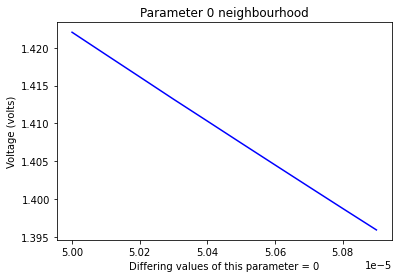

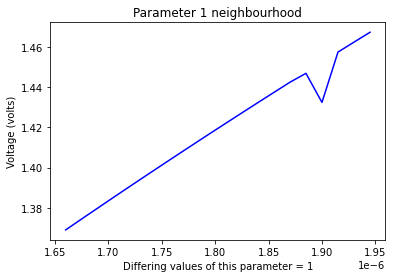

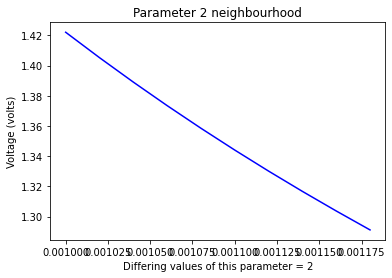

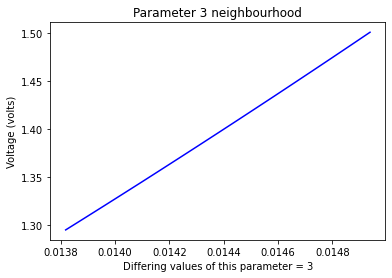

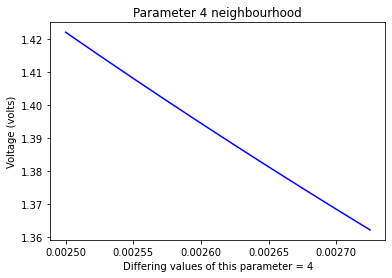

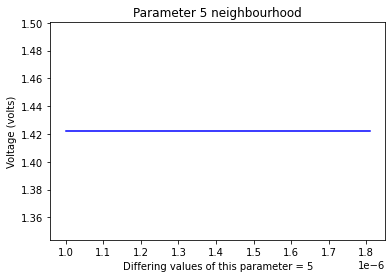

In [9]:
S =[[50e-6,60e-6],[0.5e-6, 2e-6],[1e-3, 3e-3],[8e-3,15e-3],[2.5e-3,5e-3],[1e-6,1e-5]]; 
init_size = 20;

M = Random_Pop(S,init_size) 
#print("this is the initial population: ",M) 
peakL=[] 
AVG=[] 
MED=[] 
to_tes=Evolve(M,0,10**-14,peakL,AVG,MED) 
print("Final values of the parameters are : ") 
for i in to_tes: 
    print((10**6)*i) 
print("Corresponding voltage is ",peakL[-1]) 
x = np.arange(0, len(peakL)) 

for i in range(len(to_tes)):
    fit_table=[] 
    index=[] 
    spec = to_tes[i] 
    #print("for parameter no. ",i)     
    ct=0 
    step= (S[i][1]-S[i][0])*(10**-2)     
    factor=10 
    for k1 in range(-factor,factor):
        j=(k1*step)+spec 
        if(j> S[i][1] or j< S[i][0]): 
            continue 
        temp_to_tes=to_tes.copy() 
        temp_to_tes[i]=j 
        #print(temp_to_tes,j) 
        index.append(j) 
        fit_table.append(fitness(temp_to_tes))
        
    plt.title("Parameter "+str(i)+" neighbourhood") 
    plt.xlabel("Differing values of this parameter = "+str(i))     
    plt.ylabel("Voltage (volts)") 
    plt.plot( index,fit_table , color ="blue") 
    plt.show()

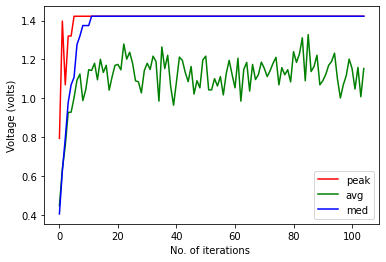

In [10]:
#checking on a randomized subset 
# mat=[] 
# factor = (10**11) 
# for j in range(6): 
#     mat.append( random.sample(range (int(S[j][0]*(factor)), int(S[j][1]*(factor))), 10**5 )) 
# output=[] 
# inputt=[] 
# res=[fitness(to_tes)]*(10**3) 
# #print(mat) 
# for i in range (10**3): 
#     inputt.append(i) 
#     vector=[] 
#     for j in range(6): 
#         vector.append(mat[j][i]/factor)     
#     output.append(fitness(vector)) 
#     #print(vector,output)
# res2=[sum(output)/len(output)]*(10**3) 
# plt.plot(inputt,res,inputt,res2,color="green") 
# plt.scatter(inputt,output) 
# plt.show() 

# plotting 
plt.xlabel("No. of iterations ") 
plt.ylabel("Voltage (volts)") 
plt.plot(x, peakL,color='r',label='peak')
plt.plot(x,AVG,color='g', label='avg')
plt.plot(x,MED,color='b', label='med')
plt.legend()
plt.show()


# Beam with optimized parameters

In [12]:
E=np.array([170e9,300e9]);
t1 = 50e-6;
t2 = 1.81e-6;
T=np.array([t1,t2]);
length = 14.52e-3;
width = 1e-3;
lp = 2.5e-3;

density=np.array([2330,3320]);
n = 2; #E.size();
Area=T*width;
volume=width*length*T;
mass=sum(volume*density);
m_added=1e-6; #%mass added to reduce the resonant frequency
meff=0.37*mass+m_added;

S=np.zeros(n);
for i in range(n):
    S[i]=sum(T[0:i+1])-T[i]/2;
N=np.array(E/E[0]);

Neu3=sum(Area*N*S)/sum(Area*N); #% neutral_axis_location from bottom

#%calculation of Hu,Hl
HL=np.zeros(n);
for i in range(n):
    HL[i]=(sum(T[0:i+1])-Neu3);
HU=np.array(HL-T);

KL=width*sum(E*abs(HU**3-HL**3))/(4*(length**3)); #%linear stifness
wn=(abs(KL)/meff)**0.5;
fn=wn/(2*3.14);
Q=20;
c=wn*meff/Q;
e0=8.85e-12;
er=8.8;
Cp=width*lp*e0*er/t2;#capacitance
em_couple=0.01; #K33_square
k0=(em_couple*KL*Cp)**0.5; #em coupling coefficient
#k0=1e-6;
Rl=1/(2*3.14*Cp*fn); # load ressistance
print("Resonant frequency fn: ",fn);

tspan=np.linspace(0,2,2500); #%time span of simulation
x0=[0,0,0];
A=5;

solF=solve_ivp(lambda T,X: Beam(T,X,k0,KL,Cp,meff,Rl,wn,A,meff,c),[0,2],x0,rtol=1e-6,t_eval=tspan); # at resonant frequency
tF=np.array(solF.t);
xF=np.array(solF.y);
voltF = max(xF[2,int(0.7*len(xF[2])):len(xF[2])]); 
print("Maximum Voltage: ",voltF); 

Resonant frequency fn:  88.98299445848428
Maximum Voltage:  1.4223130391713998


In [13]:
f=np.linspace(50,250,201);
w1=2*3.14*f;

volt = np.zeros(len(w1));
disp = np.zeros(len(w1));

for i in range(len(w1)):
    sol=solve_ivp(lambda T,X: Beam(T,X,k0,KL,Cp,meff,Rl,w1[i],A,meff,c),[0,2],x0,rtol=1e-6,t_eval=tspan);
    t=np.array(sol.t);
    x=np.array(sol.y);
    volt[i] = max(x[2,int(0.7*len(x[2])):len(x[2])]);
    disp[i] = max(x[0,int(0.7*len(x[0])):len(x[0])]);
    n0 = len(x[0]); 
    x0 = x[:,n0-1];
    print("iteration",i,"completed");

iteration 0 completed
iteration 1 completed
iteration 2 completed
iteration 3 completed
iteration 4 completed
iteration 5 completed
iteration 6 completed
iteration 7 completed
iteration 8 completed
iteration 9 completed
iteration 10 completed
iteration 11 completed
iteration 12 completed
iteration 13 completed
iteration 14 completed
iteration 15 completed
iteration 16 completed
iteration 17 completed
iteration 18 completed
iteration 19 completed
iteration 20 completed
iteration 21 completed
iteration 22 completed
iteration 23 completed
iteration 24 completed
iteration 25 completed
iteration 26 completed
iteration 27 completed
iteration 28 completed
iteration 29 completed
iteration 30 completed
iteration 31 completed
iteration 32 completed
iteration 33 completed
iteration 34 completed
iteration 35 completed
iteration 36 completed
iteration 37 completed
iteration 38 completed
iteration 39 completed
iteration 40 completed
iteration 41 completed
iteration 42 completed
iteration 43 complete

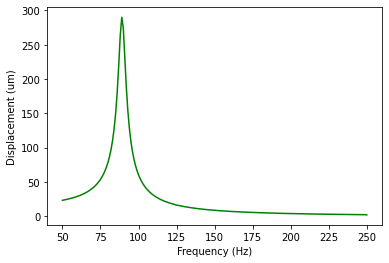

In [14]:
plt.plot(f,disp/1e-6, color='g');
plt.xlabel('Frequency (Hz)');
plt.ylabel('Displacement (um)');
#plt.title('Displacement in um vs Frequency');
plt.show();

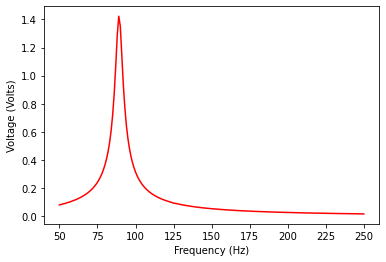

In [15]:
plt.plot(f,volt, color='r');
plt.xlabel('Frequency (Hz)');
plt.ylabel('Voltage (Volts)');
#plt.title('Voltage in volts vs Frequency');
plt.show();